# imagenet classification in tensorflow using a pretrained vgg-16 model
## koshy george, kgeorge2@gmail.com

### credits

* vgg-16.npy file, stored at 'dl.dropboxusercontent.com/u/50333326/vgg16.npy', is a  500MB vgg16 weights file

* I have used the code from [MarvinTeichmann's tensorflow implementation of fc net](https://github.com/MarvinTeichmann/tensorflow-fcn) to load the vgg-16 weights stored as an npy file at the above url, and construct a tensorflow model. While constructing the model, I have changed slightly the fully connected layers of vgg-16, as to only do matrix-multiplication and bias-addition. We are ot doing any convolutional operation in the fully connected layers of vgg-16.

*  I have obtained the imagenet class-names from [Davi Frossard's site](https://www.cs.toronto.edu/~frossard/post/vgg16)

### Additional contributions, jupyter notebook features

Also, our implementation here has got a few additional contributions, (though not necessarily have any direct bearing on either [tensorflow](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/models/image/cifar10) or deep learning), but, none the less on jupyter notebook technology.

1. **import other notebooks** Our main notebook document (that is this notebook) imports other notebooks which contain common code. Please see [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html). We use the following set of relative paths. In the example given below, *this_notebook.ipynb* imports *utils.ipynb* as a python module.
    * *this_notebook.ipynb*
    * *common*
        * *utils.ipynb*

2. **custom ipython widgets** We have written a small custom ipywidget (called <code>ProgressImageWidget</code> defined in <code>common/utils.ipynb</code>, to show incremental progress as training goes. Also we have a number of  utility classes for displaying a number of images in a grid.


### Requirements
We require [jupyter ipywidgets](https://github.com/ipython/ipywidgets) to be installed before running this notebook and we have written a small custom ipywidget to show incremental progress as training goes. [ipywidget](https://github.com/ipython/ipywidgets) is a small add-on to [jupyter](http://jupyter.org/) technology. You can easily pip install this component once you have installed [jupyter](http://jupyter.org/). 

*Before starting the server with <code>jupyter notebook --ip=0.0.0.0</code> we do the following command to ensure that widget is enabled. <code>jupyter nbextension enable --py widgetsnbextension</code>.*

As a first step, we do the following
* Import a bunch of relevant python modules
* Define a global logger 
* Amend <code>sys.path</code> to include the relative path which houses the utility python modules used here.


In [1]:
from __future__ import division, print_function, absolute_import
#ipython widget modules
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt

#other necessary modules
import os
import os.path
import sys
import time
import re
import pickle
import urllib, tarfile
from urlparse import urlparse
import PIL

#mechanism to dynamically include the relative path where utility python modules are kept to the module search path.
from inspect import getsourcefile
current_path = os.path.abspath(getsourcefile(lambda:0))
parent_dir = os.path.split(os.path.dirname(current_path))[0]
sys.path.insert(0, parent_dir)

#skimage
import skimage
import skimage.io
import skimage.transform
#tensorflow
import tensorflow as tf
import numpy as np

#logging
import logging
#set the log level to debug if you want detailed log
#logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

#load utils.ipynb which contain utility widgets
import common.load_notebooks
import common.utils
#also load the names of imagenet classes used in vgg16.npy
#credit [Davi Frossard's site](https://www.cs.toronto.edu/~frossard/post/vgg16)
from common.imagenet_classes import class_names
common.utils.logger=logger

importing Jupyter notebook from common/utils.ipynb


<IPython.core.display.Javascript object>

#### hyperparams
We store the hyper parameters in an instance of the class HyperParams, We store the <code>DatasetParams</code>, which deals with the input dataset in an instance of the class <code>DatasetParams</code>. The class <code>DatasetParams</code> also describes a generator function for iterating over the set of test images availabe at <code>DatasetParams.cropped_img_dir</code>.

#### test images
The test images available in <code>DatasetParams.cropped_img_dir</code> were taken by us, rescaled to a smaller dimension and the center 224 x 224 part was cropped. 

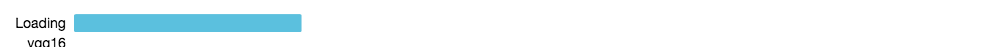

INFO:__main__:found https://dl.dropboxusercontent.com/u/50333326/vgg16.npy at ./../data/vgg-16/vgg16.npy with 553431761 bytes


In [2]:
#hyper parameters
class HyperParams(object):
    def __init__(self):
        self.n_classes=1000
        self.img_width=224
        self.img_height=224
        self.img_depth=3
        self.keep_prob=1.0

#progress widget for loading vgg16.npy
weights_loading_wdgt=widgets.FloatProgress( value=0.0, min=0, max=100.0, step=1.0, description='Loading vgg16 weights:', bar_style='info', orientation='horizontal')
 
#defines relevant directories
#and make sure that the vgg-16 weights file is downloaded
class DatasetParams(object):
    VGG_URL="https://dl.dropboxusercontent.com/u/50333326/vgg16.npy"    
    VGG_MEAN = [103.939, 116.779, 123.68]
    
    #dont consider test files whose aspect ratio is bigger than this
    LIMIT_ASPECT=4.0/3.0
    def __init__(self, dataset_dir=None):
        self.dataset_dir=dataset_dir
        self.model_filename= os.path.split(urlparse(self.VGG_URL).path)[1]
        
        #file name of expected vgg-16 weights npy file
        vgg16_weights_filepath=os.path.join(self.dataset_dir, self.model_filename)
        #try loading the weights
        if not os.path.isfile(vgg16_weights_filepath):
            DatasetParams.maybe_download_vgg16_weights_file(vgg16_weights_filepath)
        assert(os.path.isfile(vgg16_weights_filepath))
        self.data_dict = np.load(vgg16_weights_filepath, encoding='latin1').item()
        #repository of our test images
        self.cropped_img_dir=os.path.join(self.dataset_dir, 'imagenet', 'cropped')
        pass
    
    @staticmethod
    def maybe_download_vgg16_weights_file(vgg16_weights_filepath):
        expected_size_of_vgg16_dot_npy=553431761
        def _progress(count, block_size, total_size):
            weights_loading_wdgt.value = float(count * block_size) / float(total_size) * 100.0
            #logger.info('\r>> Downloading %s %.1f%%' % (vgg16_weights_filepath, float(count * block_size) / float(total_size) * 100.0))
        
        need_to_download =  not os.path.isfile(vgg16_weights_filepath) or os.stat(vgg16_weights_filepath).st_size != expected_size_of_vgg16_dot_npy
        if need_to_download:
            try:
                display(weights_loading_wdgt)
                new_filepath, _ = urllib.urlretrieve(DatasetParams.VGG_URL, vgg16_weights_filepath, _progress)
 
            except IOError:
                weights_loading_wdgt.bar_style='danger'
                pass
        assert(os.path.isfile(vgg16_weights_filepath))
        statinfo = os.stat(vgg16_weights_filepath)
        logger.info('found {u} at {f} with {b} bytes'.format(u=DatasetParams.VGG_URL, f=vgg16_weights_filepath, b=statinfo.st_size))
       

    def is_image_valid(self, filepath):
        global hyper_params
        b_good_img=False
        try:
            with PIL.Image.open(filepath) as im:
                b_good_img = im.size == (hyper_params.img_width, hyper_params.img_height)
        except IOError:
            pass
        return b_good_img
    
    #generator which iterates over all the available test files
    def get_test_images(self):
        for root, dirs, files in os.walk(self.cropped_img_dir):
            for f in files:
                src_img_path=os.path.join(root, f)
                assert(self.is_image_valid(src_img_path))
                yield src_img_path
    
    
hyper_params=HyperParams()
dataset_params=DatasetParams(dataset_dir='./../data/vgg-16')


In [3]:


class Net(object):
    def __init__(self, debug=True):
        self.debug=debug
    
    #build the model from the vgg16 weigt matrix   
    def build(self, placeholder_x=None, placeholder_dropout_control=None):
        assert(placeholder_x != None)
        assert(placeholder_dropout_control != None)
        
        with tf.name_scope("p"):
            #get the image data and convert it to BGR
            #subtract the mean values
            red,green, blue= tf.split(3,3, placeholder_x)
            red = tf.cast(red, dtype=tf.float32)
            green =  tf.cast(green, dtype=tf.float32)
            blue =  tf.cast(blue, dtype=tf.float32)
            red -=  DatasetParams.VGG_MEAN[2]
            green -=  DatasetParams.VGG_MEAN[1]
            blue  -=  DatasetParams.VGG_MEAN[0]
            bgr= tf.concat(3, [blue, green, red])
        
        if self.debug:
            bgr = tf.Print(bgr, [tf.shape(bgr)],
                               message='Shape of input image: ',
                               summarize=4, first_n=1)
        #convolutional layers
        self.conv1_1 = self._conv_layer(bgr, 'conv1_1')
        self.conv1_2 = self._conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self._max_pool(self.conv1_2, 'pool1', self.debug)

        self.conv2_1 = self._conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self._conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self._max_pool(self.conv2_2, 'pool2', self.debug)

        self.conv3_1 = self._conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self._conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self._conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self._max_pool(self.conv3_3, 'pool3', self.debug)

        self.conv4_1 = self._conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self._conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self._conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self._max_pool(self.conv4_3, 'pool4', self.debug)

        self.conv5_1 = self._conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self._conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self._conv_layer(self.conv5_2, "conv5_3")
        self.pool5 = self._max_pool(self.conv5_3, 'pool5', self.debug)
        #fully connected layers
        self.fc6 = tf.nn.dropout(self._fc_layer(self.pool5, "fc6"), keep_prob)
        self.fc7 = tf.nn.dropout(self._fc_layer(self.fc6, "fc7"), keep_prob)
        self.fc8 = self._fc_layer(self.fc7, "fc8", relu=False)
        #get the class with the maximum softmax output
        self.pred = tf.argmax(tf.nn.softmax(self.fc8), dimension=1)
        

        self.get_summary()


    def _conv_layer(self, bottom, name):
        with tf.variable_scope(name) as scope:
            filt = self.get_conv_filter(name)
            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')
            conv_biases = self.get_bias(name)
            biased = tf.nn.bias_add(conv, conv_biases)
            relu = tf.nn.relu(biased)
            return relu

    def _max_pool(self, bottom, name, debug):
        pool = tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                              padding='SAME', name=name)
        if debug:
            pool = tf.Print(pool, [tf.shape(pool)],
                            message='Shape of %s' % name,
                            summarize=4, first_n=1)
        return pool



    def _fc_layer(self, bottom, name, num_classes=None,
                  relu=True, debug=False):
        with tf.variable_scope(name) as scope:
        
            shape = int(np.prod(bottom.get_shape().as_list()[1:]))
            if name == 'fc6':
                filt = self.get_fc_weight_reshape(name, [shape,  4096])
            elif name == 'fc8':
                filt = self.get_fc_weight_reshape(name, [ 4096, 1000])
            else:
                filt = self.get_fc_weight_reshape(name, [4096, 4096])
            bottom_1 = tf.reshape(bottom, [-1, shape])
            
            bias = self.get_bias(name)
            bias =  tf.nn.bias_add(tf.matmul(bottom_1,  filt), bias)
            
            if relu:
                bias = tf.nn.relu(bias)

            if debug:
                bias = tf.Print(bias, [tf.shape(bias)],
                                message='Shape of %s' % name,
                                summarize=4, first_n=1)

            return bias
        
        
    def get_summary(self):
        logger.debug('variables %r' % [ v.name for v in tf.get_collection(tf.GraphKeys.VARIABLES)])
        logger.debug('trinable variables %r' % [ v.name for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        logger.debug('summaries %r' % [v.name for v in tf.get_collection(tf.GraphKeys.SUMMARIES)])
    



    def get_fc_weight_reshape(self, name, shape, num_classes=None):
        global dataset_params
        logger.debug('Layer name: %s' % name)
        logger.debug('Layer shape: %s' % shape)
        weights = dataset_params.data_dict[name][0]
        weights = weights.reshape(shape)
        init = tf.constant_initializer(value=weights,
                                       dtype=tf.float32)
        return tf.get_variable(name="weights", initializer=init, shape=shape)



    def get_bias(self, name):
        global dataset_params
        bias_wights = dataset_params.data_dict[name][1]
        shape = dataset_params.data_dict[name][1].shape
        init = tf.constant_initializer(value=bias_wights,
                                       dtype=tf.float32)
        return tf.get_variable(name="biases", initializer=init, shape=shape)

    def get_conv_filter(self, name):
        global dataset_params
        init = tf.constant_initializer(value=dataset_params.data_dict[name][0],
                                       dtype=tf.float32)
        shape = dataset_params.data_dict[name][0].shape
        logger.debug('Layer name: %s' % name)
        logger.debug('Layer shape: %s' % str(shape))
        var = tf.get_variable(name="filter", initializer=init, shape=shape)
        return var    
    

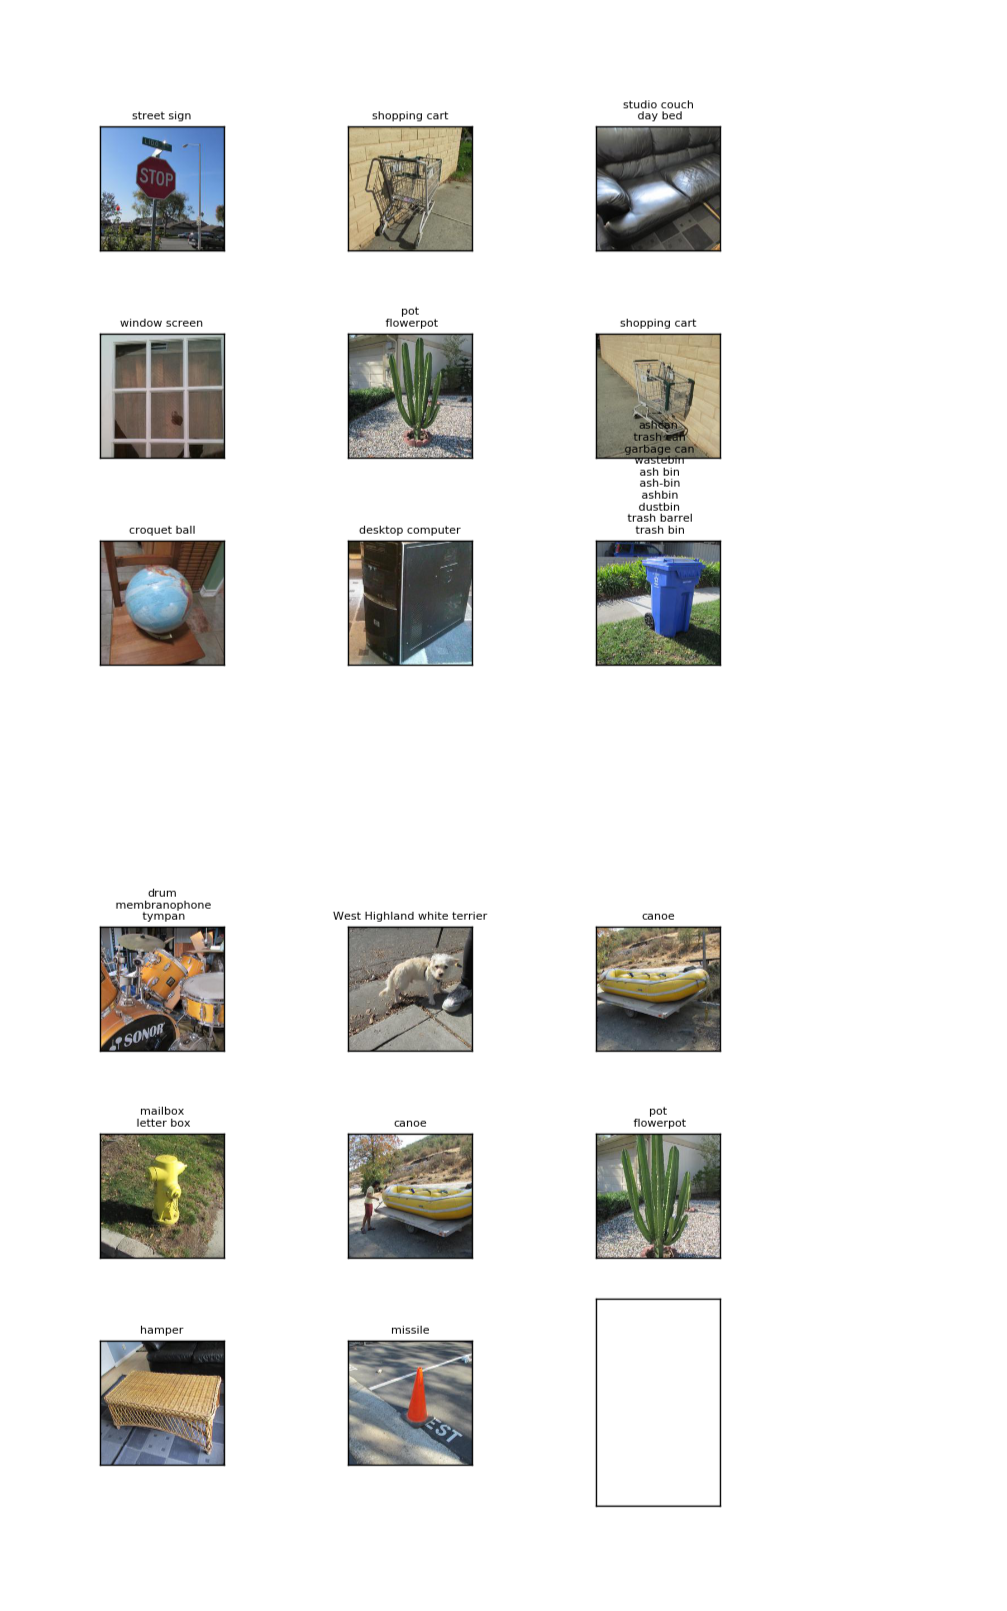

INFO:__main__:start testing
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/shopping_cart_1.jpg, result=shopping cart
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/couch2.jpg, result=studio couch, day bed


common/utils.ipynb:66: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  "source": [


INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/globe-1.jpg, result=croquet ball
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/window.jpg, result=window screen
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/shopping_cart_2.jpg, result=shopping cart
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/cactus_2.jpg, result=pot, flowerpot
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/stop_sign.jpg, result=street sign
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/desktop.jpg, result=desktop computer
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/garbage_bin.jpg, result=ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/wicker_table.jpg, result=hamper
INFO:__main__:testing img ./../data/vgg-16/imagenet/cropped/traffic_cone.jpg, result=missile
INFO:__main__:testing img ./../data/vgg-16/imagenet/cro

In [4]:

#for managing grid of images tested
#see common.tils.ipynb
grid_contoller=common.utils.ImgGridController()
display(grid_contoller.top_level)

with tf.Graph().as_default():
    logger.info('start testing')
    #params
    global hyper_params, dataset_params
    
    #placeholders
    is_train = tf.placeholder(tf.bool)
    X = tf.placeholder(tf.float32, 
                       shape=(1, hyper_params.img_height, hyper_params.img_width, hyper_params.img_depth))
    keep_prob = tf.placeholder(tf.float32)
    
    net=Net(debug=True)
    logits=net.build(placeholder_x=X, placeholder_dropout_control=keep_prob)
    init = tf.initialize_all_variables()
    
    #subroutine for running all the test-images in dataset_params.
    def run_test(data=None, labels=None):
        global dataset_params
        #generetor fr iterating over test images
        imgs_gen=dataset_params.get_test_images()
        try:
            while True:
                next_img_path=imgs_gen.next()
                img1 = skimage.io.imread(next_img_path)
                #make it in placeholder format
                img1=np.expand_dims(img1, 0)
                assert(img1.shape[0] == 1)
                assert(img1.shape[3] == hyper_params.img_depth)
                assert(img1.shape[1] == hyper_params.img_height)
                assert(img1.shape[2] == hyper_params.img_width)
                feed_dict={X: img1, keep_prob:hyper_params.keep_prob}
                targets=[net.pred]
                p=sess.run(targets, feed_dict=feed_dict)
                out_class=np.argmax(p)
                
                logger.info('testing img {i}, result={r}'.format(i=next_img_path, r=class_names[p[0][0]]))
                grid_contoller.add_img(img_path=next_img_path, data={'class_name': class_names[p[0][0]]})   
                #if img_grid.cached_img_dataurl != None:
                #    img_grid_wdgt.value=img_grid.cached_img_dataurl
        except StopIteration:
            pass
        pass
    
    with tf.Session() as sess:
        sess.run(init)
        run_test()
        logger.info('done testing')